# Time Series Models

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import datetime as dt

In [154]:
data = pd.read_parquet("Data/DSB_BDK_trainingset.parquet")
punktlighed_per_date = data.groupby('dato')['togpunktlighed'].mean()

In [155]:
punktlighed_per_date = pd.DataFrame(punktlighed_per_date).reset_index()

# Seasonality

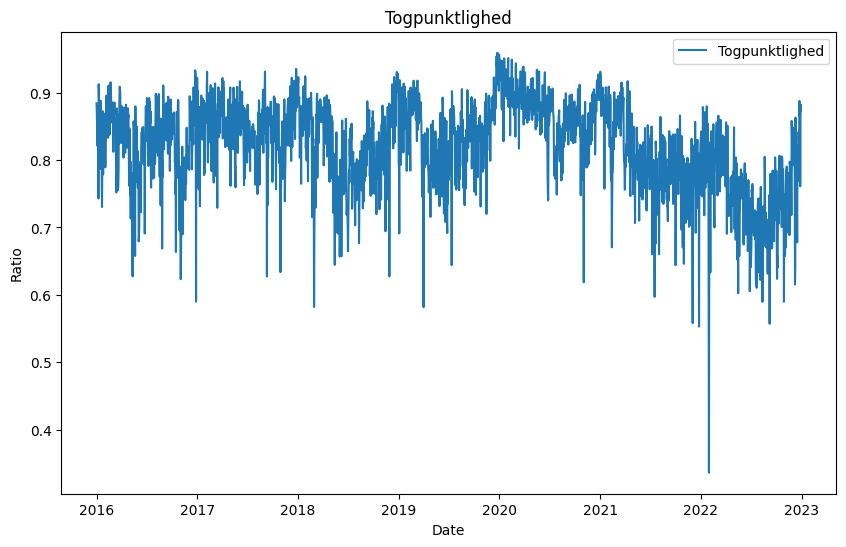

In [156]:
start_date = 0
interval = -1
punktlighed_per_date_plot = punktlighed_per_date.iloc[start_date:start_date+interval]
plt.figure(figsize=(10,6))
plt.plot(punktlighed_per_date_plot['dato'], punktlighed_per_date_plot['togpunktlighed'], label='Togpunktlighed')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Togpunktlighed')
plt.show()

In [157]:
# Monthly Average
punktlighed_per_date['year'] = punktlighed_per_date['dato'].dt.strftime('%Y')
punktlighed_per_date['month'] = punktlighed_per_date['dato'].dt.strftime('%-m')
punktlighed_per_date['day'] = punktlighed_per_date['dato'].dt.strftime('%-d')

In [158]:
monthly_mean = punktlighed_per_date['togpunktlighed'].groupby([punktlighed_per_date['year'], punktlighed_per_date['month']]).mean()

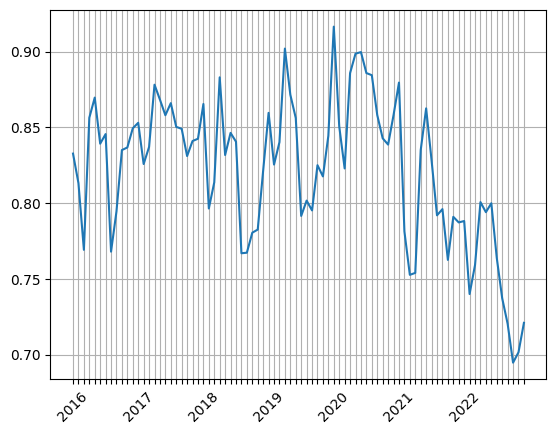

In [159]:
plt.plot(monthly_mean.values, label='Togpunktlighed')
tick_labels = [f"{monthly_mean.index[i][0]}" if i == 0 or monthly_mean.index[i][0] != monthly_mean.index[i-1][0] else "" for i in range(len(monthly_mean.index))]
plt.xticks(range(len(monthly_mean.index)), tick_labels, rotation=45)
plt.grid()
plt.show()

/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_1749/535571475.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = monthly_mean[i] - monthly_mean[i - months_in_year] # Same date last year


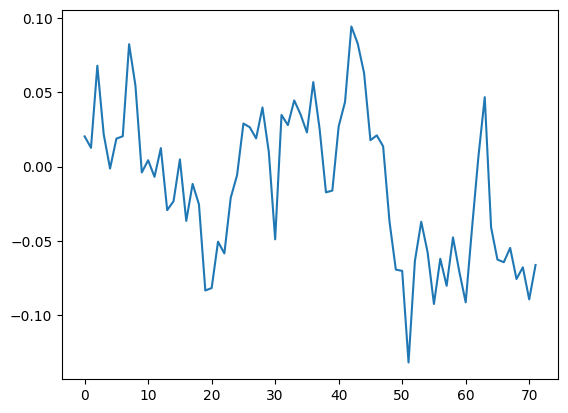

In [160]:
diff = list()
months_in_year = 12
for i in range(months_in_year, len(monthly_mean)):
 value = monthly_mean[i] - monthly_mean[i - months_in_year] # Same date last year
 diff.append(value)
plt.plot(diff)
plt.show()

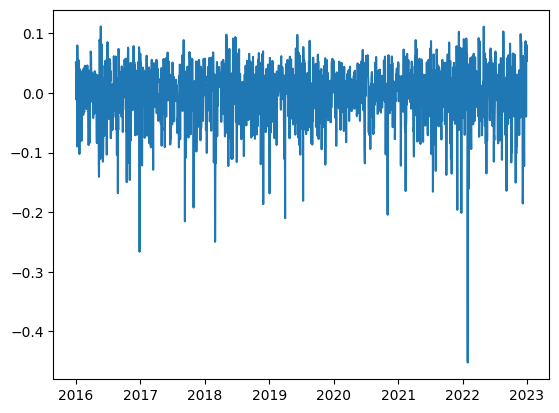

In [161]:
diff = list()
series = punktlighed_per_date['togpunktlighed']
X_1 = series.values
days_in_year = 365
year_list = []
month_list = []
for i in range(len(X_1)):
    if punktlighed_per_date['year'][i] not in year_list:
        filtered_data = punktlighed_per_date[punktlighed_per_date['year'] == punktlighed_per_date['year'][i]]
        month_list = []
    if punktlighed_per_date['month'][i] not in month_list:
       filtered_data = filtered_data[filtered_data['month'] == filtered_data['month'][i]]
 
    month_mean_last_year = filtered_data['togpunktlighed'].mean()
    value = X_1[i] - month_mean_last_year
    diff.append(value)
plt.plot(punktlighed_per_date['dato'], diff)
plt.show()

A yearly seasonality could be present - the togpunktlighed is better in the winter time/early spring and declines with summer's approach. 

# Simple Moving Average (SMA)

In [162]:
punktlighed_per_date['SMA'] = punktlighed_per_date['togpunktlighed'].rolling(window=3).mean()

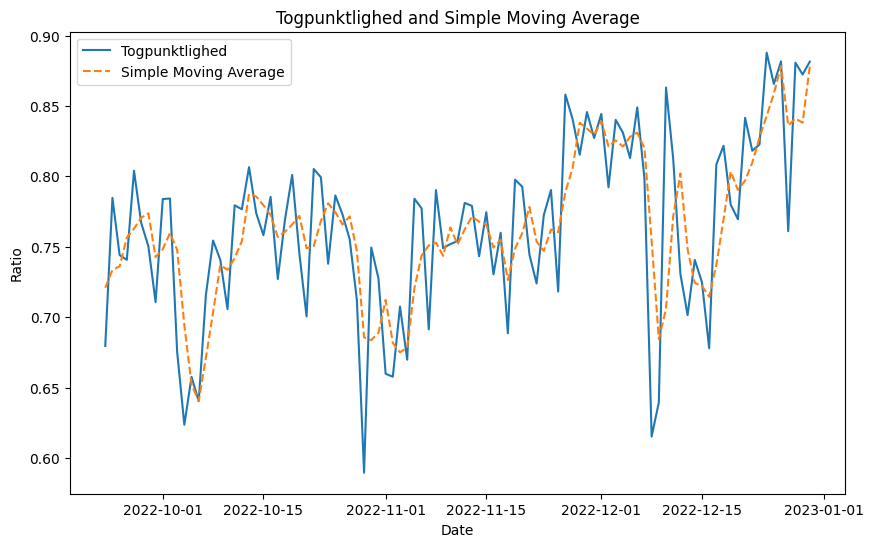

In [163]:
punktlighed_per_date_plot = punktlighed_per_date.iloc[-100:-1,:]
plt.figure(figsize=(10,6))
plt.plot(punktlighed_per_date_plot['dato'], punktlighed_per_date_plot['togpunktlighed'], label='Togpunktlighed')
plt.plot(punktlighed_per_date_plot['dato'], punktlighed_per_date_plot['SMA'], label='Simple Moving Average', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Togpunktlighed and Simple Moving Average')
plt.show()

In [164]:
punktlighed_per_date.fillna({'SMA': punktlighed_per_date['togpunktlighed']}, inplace=True)
punktlighed_per_date['SMA'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
2552    False
2553    False
2554    False
2555    False
2556    False
Name: SMA, Length: 2557, dtype: bool

In [165]:
# Evaluate the model
mse_SMA = mean_squared_error(punktlighed_per_date['togpunktlighed'], punktlighed_per_date['SMA'])
print(f'Mean Squared Error of Model: {mse_SMA}')

Mean Squared Error of Model: 0.0010599525644939618


# Exponential Moving Average (EMA)

In [166]:
punktlighed_per_date['EMA'] = punktlighed_per_date['togpunktlighed'].ewm(alpha=0.6, adjust=True).mean()

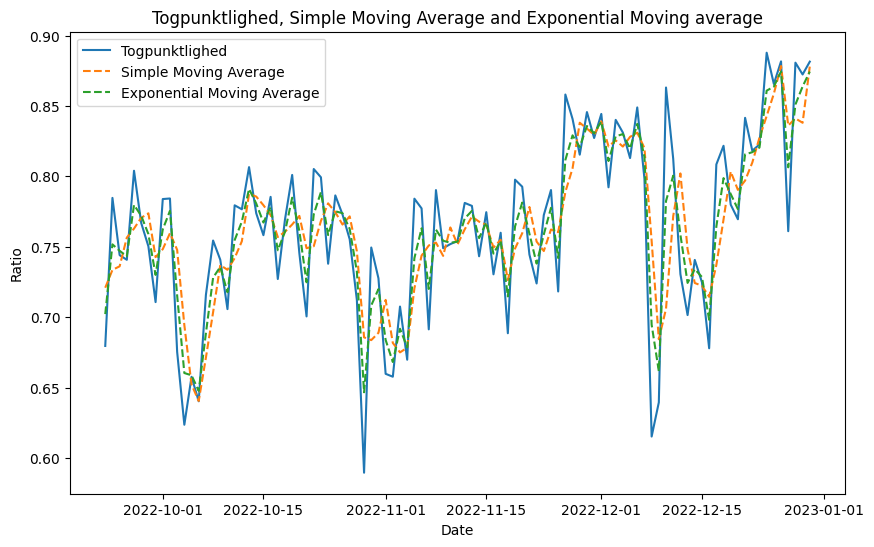

In [167]:
punktlighed_per_date_plot = punktlighed_per_date.iloc[-100:-1,:]
plt.figure(figsize=(10,6))
plt.plot(punktlighed_per_date_plot['dato'], punktlighed_per_date_plot['togpunktlighed'], label='Togpunktlighed')
plt.plot(punktlighed_per_date_plot['dato'], punktlighed_per_date_plot['SMA'], label='Simple Moving Average', linestyle='--')
plt.plot(punktlighed_per_date_plot['dato'], punktlighed_per_date_plot['EMA'], label='Exponential Moving Average', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Togpunktlighed, Simple Moving Average and Exponential Moving average')
plt.show()

In [168]:
punktlighed_per_date.fillna({'EMA': punktlighed_per_date['togpunktlighed']}, inplace=True)
punktlighed_per_date['EMA'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
2552    False
2553    False
2554    False
2555    False
2556    False
Name: EMA, Length: 2557, dtype: bool

In [169]:
# Evaluate the model
mse_EMA = mean_squared_error(punktlighed_per_date['togpunktlighed'], punktlighed_per_date['EMA'])
print(f'Mean Squared Error of Model: {mse_EMA}')

Mean Squared Error of Model: 0.0003379404116783206


# ARMA Model
d=0 makes the ARIMA model behave as ARMA

In [170]:
arima_model = ARIMA(endog=punktlighed_per_date['togpunktlighed'], order=(1, 0, 1))
fit_arima_model = arima_model.fit()

In [171]:
arima_forecast = fit_arima_model.get_forecast(steps=10)

In [172]:
arima_forecast.predicted_mean.values

array([0.85650894, 0.85482409, 0.85322185, 0.85169817, 0.85024921,
       0.84887128, 0.84756092, 0.84631482, 0.84512981, 0.8440029 ])

In [173]:
fit_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         togpunktlighed   No. Observations:                 2557
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4339.034
Date:                Mon, 26 Feb 2024   AIC                          -8670.067
Time:                        09:31:52   BIC                          -8646.681
Sample:                             0   HQIC                         -8661.587
                               - 2557                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8221      0.008    102.242      0.000       0.806       0.838
ar.L1          0.9510      0.007    127.837      0.000       0.936       0.966
ma.L1         -0.6129      0.015    -41.617      0.000      -0.642      -0.584
sigma2         0.0020   3.31e-05     59.401      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                  34.68   Jarque-Bera (JB):              3688.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -1.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

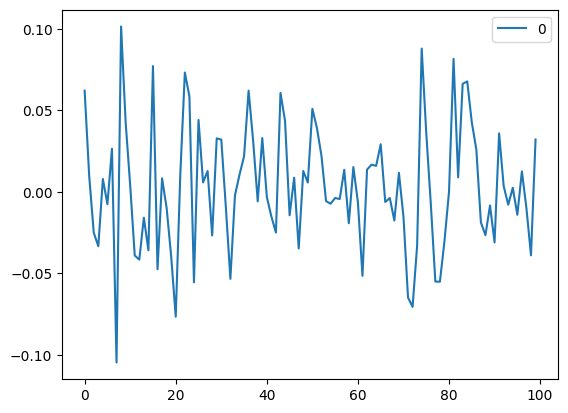

In [174]:
# line plot of residuals
no_obs = 100
residuals = pd.DataFrame(fit_arima_model.resid)
residuals[:no_obs].plot()
plt.show()

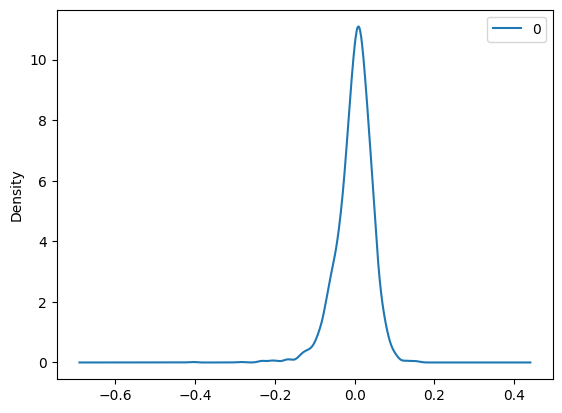

In [175]:
residuals.plot(kind='kde')
plt.show()

In [176]:
# summary stats of residuals
print(residuals.describe())

                 0
count  2557.000000
mean     -0.000056
std       0.044349
min      -0.407302
25%      -0.021682
50%       0.005351
75%       0.027661
max       0.157957


In [177]:
size = int(len(punktlighed_per_date['togpunktlighed']) * 0.80)
train, test = punktlighed_per_date['togpunktlighed'].values[0:size], punktlighed_per_date['togpunktlighed'].values[size:len(punktlighed_per_date['togpunktlighed'])]
history = [x for x in train]

In [178]:
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(3,3,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))

/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood

In [179]:
# Evaluate the model
mse_ARMA = mean_squared_error(test, predictions)
print(f'Mean Squared Error of Model: {mse_ARMA}')

Mean Squared Error of Model: 0.0032027908212829315


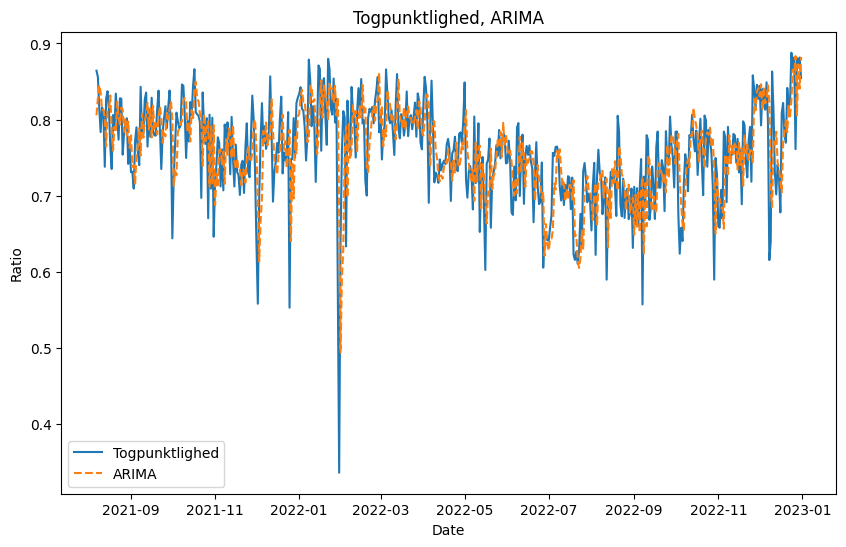

In [180]:
plt.figure(figsize=(10,6))
plt.plot(punktlighed_per_date['dato'][-len(test):], test, label='Togpunktlighed')
plt.plot(punktlighed_per_date['dato'][-len(test):], predictions, label=f'ARIMA', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Togpunktlighed, ARIMA')
plt.show()

# Seasonal ARIMA (SARIMA)